In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [3]:
include("../src/unit_commitments.jl")

# A spring day
n=100
T_period = (n*24+6):(n*24+29)

loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]

gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 49244 rows; 26208 cols; 146490 nonzeros; 10008 integer variables (10008 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
35455 rows, 25789 cols, 126409 nonzeros  0s
26922 rows, 20568 cols, 109345 nonzeros  0s
19988 rows, 18922 cols, 99616 nonzeros  0s
16924 rows, 16140 cols, 95014 nonzeros  1s
15446 rows, 14760 cols, 90719 nonzeros  2s

Solving MIP model with:
   15446 rows
   14760 cols (8485 binary, 0 integer, 0 implied int., 6275 continuous, 0 domain fixed)
   90719 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =>

In [4]:
# stop halfway through
recommit_time = 12
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time + recommit_time):(final_time)

# perturb data
gen_var_actuals = copy(gen_var_multi)
gen_var_actuals.cf .= gen_var_actuals.cf .* (0.95 .+ 0.1 .* rand(nrow(gen_var_actuals)));
loads_multi.demand .= loads_multi.demand .* 1.2;

loads_multi_ruc = loads_multi[in.(loads_multi.hour,Ref(T_period)),:]
ruc_gen_var_multi = gen_var_actuals[in.(gen_var_actuals.hour, Ref(T_period)), :]

# gen_vre = gen_df[gen_df[!,:vre] .== 1, :r_id]
# mask = in.(ruc_gen_var_multi.r_id, Ref(gen_vre))
# ruc_gen_var_multi[mask, :cf] .*= 1.5 # it's real sunny ! and windy !

ruc_solution = reliability_uc(
    solution.decision_vars, n*24+6 + recommit_time,
    gen_df, loads_multi_ruc, ruc_gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 24625 rows; 13104 cols; 68099 nonzeros; 5004 integer variables (3198 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
Presolve: Infeasible

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -inf            inf     

In [ ]:
ruc_actual_solution = evaluate_ruc_commitment_on_actuals(
    solution,           # Initial UC
    ruc_solution,       # RUC solution
    n*24+6 + recommit_time,  # Transition hour
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 36322 rows; 19536 cols; 85664 nonzeros; 3336 integer variables (0 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [1e+00, 1e+04]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 3e+05]
Presolving model
3847 rows, 4245 cols, 10571 nonzeros  0s
1467 rows, 3126 cols, 6198 nonzeros  0s
1467 rows, 3126 cols, 6198 nonzeros  0s

Solving MIP model with:
   1467 rows
   3126 cols (0 binary, 0 integer, 0 implied int., 3126 continuous, 0 domain fixed)
   6198 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds      

(model = A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 19536
├ num_constraints: 58570
│ ├ AffExpr in MOI.EqualTo{Float64}: 3774
│ ├ AffExpr in MOI.GreaterThan{Float64}: 4008
│ ├ AffExpr in MOI.LessThan{Float64}: 28540
│ ├ VariableRef in MOI.EqualTo{Float64}: 3336
│ ├ VariableRef in MOI.GreaterThan{Float64}: 15576
│ └ VariableRef in MOI.ZeroOne: 3336
└ Names registered in the model
  └ :AuxGen, :CHARGE, :COMMIT, :Cap_nt_nonvar, :Cap_thermal_max, :Cap_thermal_min, :Cap_var, :ChargeCap, :DISCHARGE, :DischargeCap, :FLOW, :FlowMax, :FlowMin, :GEN, :GENAUX, :LOADSHED, :NodalBalance, :RESDN, :RESUP, :RampDn_nonthermal, :RampDn_thermal, :RampUp_nonthermal, :RampUp_thermal, :ResDnCap, :ResDnRamp, :ResDnRequirement, :ResUpCap, :ResUpRamp, :ResUpRequirement, :SOC, :SOCCap, :cStateOfCharge, :cStateOfChargeEnd, :cStateOfChargeStart, gen = 4848×3 DataFrame
  Row │ r_id   hour   gen       
      │ Int64  Int64  Float64   
──────┼──────

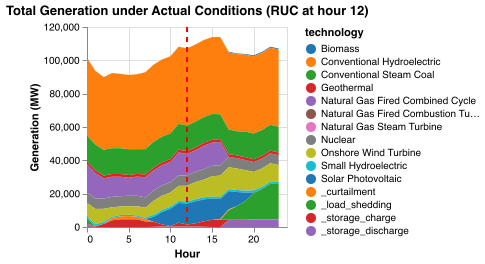

In [6]:
include("../src/plots.jl")

plot_actual_ruc_generation(
    ruc_actual_solution,
    n*24+6,
    recommit_time,
    gen_df,
    zone_dict,
    "Total Generation under Actual Conditions"
);

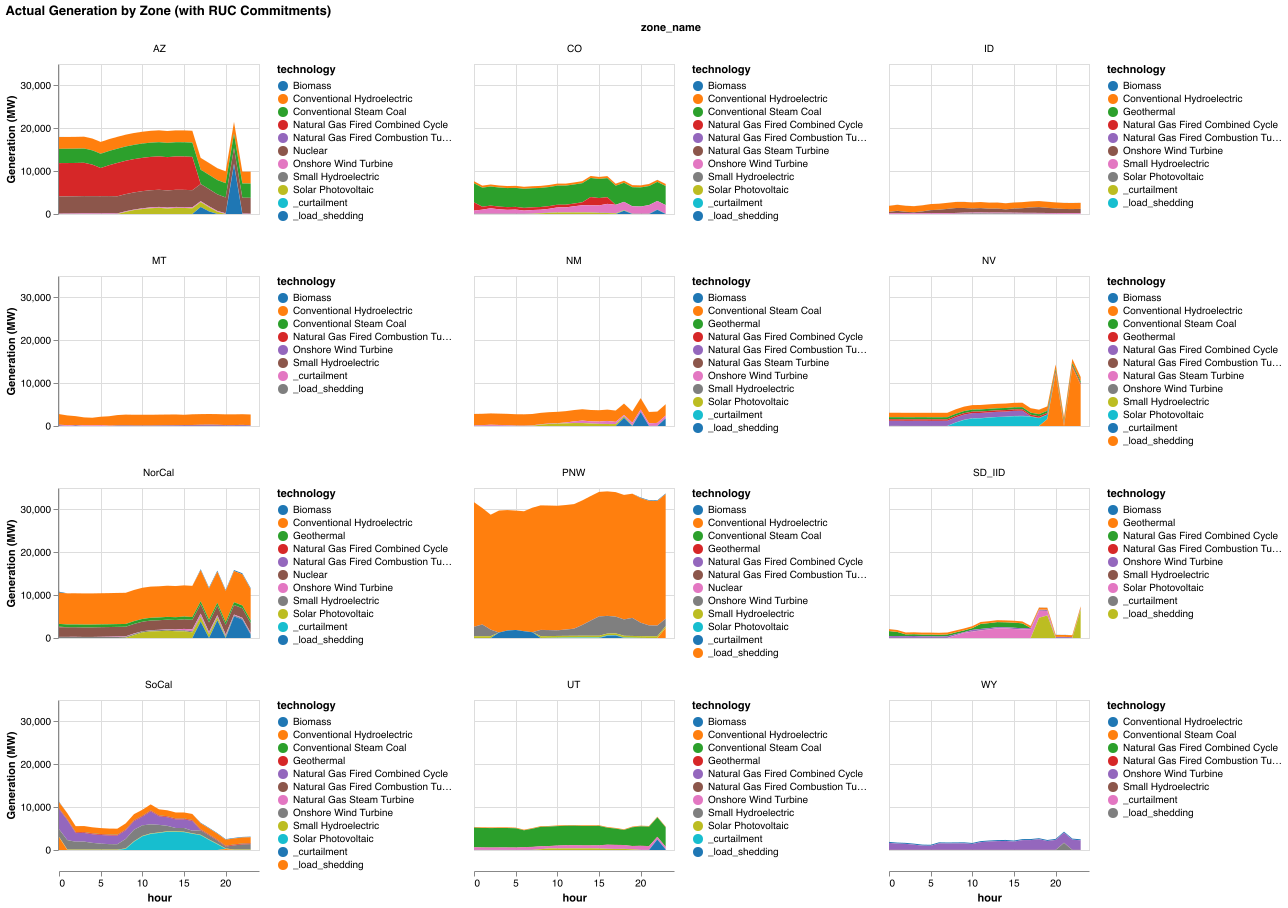

In [7]:
plot_actual_generation_by_zone(
    ruc_actual_solution,
    n*24+6,
    gen_df,
    zone_dict,
    "Actual Generation by Zone (with RUC Commitments)"
);

In [9]:
include("../src/network_analysis.jl")
plots_dir = "evaluation_RUC_plots"
if !isdir(plots_dir)
    mkpath(plots_dir)
end

plot_power_network(
    ruc_actual_solution.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "network_hour_2418.png")
)

animate_power_network(
    ruc_actual_solution.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "network_animation.gif")
)

plot_flow_heatmap(
    ruc_actual_solution.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "flow_heatmap.png")
)

# compare_network_flows(
#     solution.flows,
#     ruc_solution.flows,
#     network,
#     gen_df,
#     zone_dict;
#     hour=2418,
#     save_path=joinpath(plots_dir, "flow_comparison.png")
# )

plot_congestion_analysis(
    ruc_actual_solution.flows,
    network;
    save_path=joinpath(plots_dir, "congestion_analysis.png")
);

[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/model_notebooks/evaluation_RUC_plots/network_animation.gif


Animation saved to evaluation_RUC_plots/network_animation.gif
